ANÁLISIS DE CORRELACIÓN - SELECCIÓN DE CARACTERÍSTICAS
Dimensiones del dataset: (578824, 21)
Variables disponibles: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']

Primeras filas:
       ID  PERIODO  ESTU_PRGM_ACADEMICO  ESTU_PRGM_DEPARTAMENTO  \
0  904256        7                  297                       4   
1  645256        7                  246                       3   
2  308367        6                  813                       4   
3  989032        7                  899                       1   
4   47159        0                  452                      16   

   ESTU_VALORMATRICULAUNIVERSIDAD  E

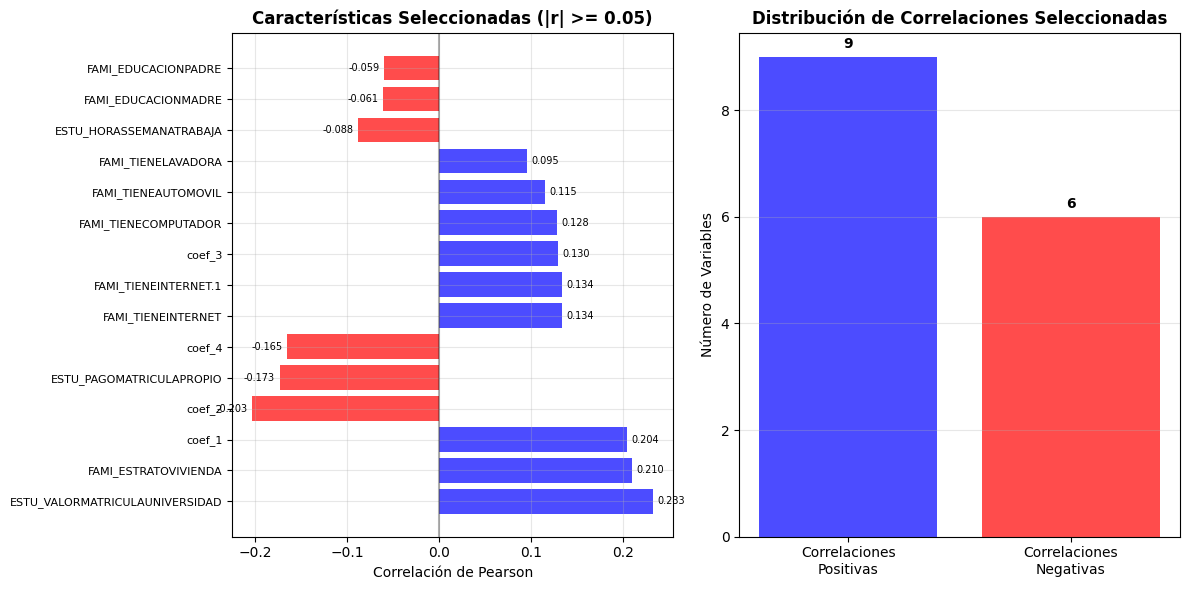


RESUMEN FINAL - SELECCIÓN Y FILTRADO DE CARACTERÍSTICAS
📁 ARCHIVO ORIGINAL: 578,824 filas × 21 columnas
📁 ARCHIVO FILTRADO: 578,824 filas × 17 columnas
🎯 UMBRAL APLICADO: |r| >= 0.05
✂️  CARACTERÍSTICAS ELIMINADAS: 4 columnas
✅ CARACTERÍSTICAS MANTENIDAS: 15 variables + ID + target
📈 CORRELACIONES POSITIVAS: 9
📉 CORRELACIONES NEGATIVAS: 6
💾 UBICACIÓN: /home/jp/Repositorios/UDEA/InteligenciaArtificial-UdeA20251/Data/Processed/train_selected_features.csv
🕒 FECHA: 2025-06-13 14:00:01
✅ PROCESO COMPLETADO EXITOSAMENTE


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
import warnings
import os
warnings.filterwarnings('ignore')

print("ANÁLISIS DE CORRELACIÓN - SELECCIÓN DE CARACTERÍSTICAS")
print("="*60)

# 1. CARGAR Y EXPLORAR DATOS
df = pd.read_csv('/home/jp/Repositorios/UDEA/InteligenciaArtificial-UdeA20251/Data/train_preprocessed.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"Variables disponibles: {list(df.columns)}")
print(f"\nPrimeras filas:")
print(df.head())

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 2. PREPARAR DATOS PARA CORRELACIÓN
print(f"\n" + "="*50)
print("PREPARANDO DATOS PARA ANÁLISIS DE CORRELACIÓN")
print("="*50)

# Crear copia para procesar
df_corr = df.copy()

# Identificar tipos de variables
categorical_vars = []
numerical_vars = []
target_var = 'RENDIMIENTO_GLOBAL'

for col in df_corr.columns:
    if col == 'ID':  # Excluir ID
        continue
    elif col == target_var:
        continue
    elif df_corr[col].dtype == 'object' or df_corr[col].dtype == 'bool':
        categorical_vars.append(col)
    else:
        numerical_vars.append(col)

print(f"Variables categóricas encontradas: {len(categorical_vars)}")
print(categorical_vars)
print(f"\nVariables numéricas encontradas: {len(numerical_vars)}")
print(numerical_vars)

# 3. CODIFICAR VARIABLES CATEGÓRICAS
print(f"\nCodificando variables categóricas...")

# Codificar target (RENDIMIENTO_GLOBAL) con orden
rendimiento_order = ['bajo', 'medio-bajo', 'medio-alto', 'alto']
df_corr[target_var] = pd.Categorical(df_corr[target_var], categories=rendimiento_order, ordered=True)
df_corr[target_var] = df_corr[target_var].cat.codes

# Codificar otras variables categóricas
label_encoders = {}
for col in categorical_vars:
    if col != target_var:
        le = LabelEncoder()
        df_corr[col] = le.fit_transform(df_corr[col].astype(str))
        label_encoders[col] = le

print(f"Variables codificadas exitosamente")

# 4. CALCULAR CORRELACIONES DE PEARSON
print(f"\n" + "="*50)
print("CALCULANDO CORRELACIONES DE PEARSON")
print("="*50)

# Seleccionar solo variables numéricas (incluyendo las categóricas codificadas)
features_for_correlation = numerical_vars + categorical_vars
df_features = df_corr[features_for_correlation + [target_var]].copy()

# Manejar valores faltantes
df_features = df_features.dropna()
print(f"Muestras después de eliminar NaN: {len(df_features)}")

# Calcular matriz de correlación completa
correlation_matrix = df_features.corr(method='pearson')

# Extraer correlaciones con la variable target
target_correlations = correlation_matrix[target_var].drop(target_var)
target_correlations_abs = target_correlations.abs().sort_values(ascending=False)

print(f"\nCORRELACIONES CON {target_var} (ordenadas por valor absoluto):")
print("-" * 60)
for var, corr in target_correlations_abs.items():
    original_corr = target_correlations[var]
    print(f"{var:30s}: {original_corr:7.3f} (|{corr:.3f}|)")

# 5. CONFIGURAR FILTROS DE CORRELACIÓN Y RUTA DE SALIDA
print(f"\n" + "="*60)
print("CONFIGURACIÓN DE FILTROS Y UBICACIÓN DE SALIDA")
print("="*60)

# PARÁMETROS CONFIGURABLES - MODIFICA ESTOS VALORES SEGÚN TUS NECESIDADES
UMBRAL_CORRELACION = 0.05  # Valor mínimo de correlación absoluta para considerar
RUTA_SALIDA = '/home/jp/Repositorios/UDEA/InteligenciaArtificial-UdeA20251/Data/Processed/'  # Cambia esta ruta
NOMBRE_ARCHIVO = 'train_selected_features.csv'

print(f"Umbral de correlación: |r| >= {UMBRAL_CORRELACION}")
print(f"Ruta de salida: {RUTA_SALIDA}")
print(f"Nombre del archivo: {NOMBRE_ARCHIVO}")

# Crear directorio si no existe
os.makedirs(RUTA_SALIDA, exist_ok=True)

# 6. FILTRAR CARACTERÍSTICAS CON ALTA CORRELACIÓN
print(f"\n" + "="*50)
print("FILTRANDO CARACTERÍSTICAS CON ALTA CORRELACIÓN")
print("="*50)

# Filtrar variables que superan el umbral
high_corr_vars = target_correlations_abs[target_correlations_abs >= UMBRAL_CORRELACION].index.tolist()

print(f"Variables que superan el umbral |r| >= {UMBRAL_CORRELACION}:")
print(f"Total encontradas: {len(high_corr_vars)} de {len(target_correlations_abs)} variables analizadas")
print("-" * 60)

for i, var in enumerate(high_corr_vars, 1):
    corr_val = target_correlations[var]
    abs_corr = abs(corr_val)
    tipo_corr = "POSITIVA" if corr_val > 0 else "NEGATIVA"
    print(f"{i:2d}. {var:30s}: {corr_val:7.3f} ({tipo_corr} - |{abs_corr:.3f}|)")

# 7. CREAR DATASET FILTRADO
print(f"\n" + "="*50)
print("CREANDO DATASET CON CARACTERÍSTICAS SELECCIONADAS")
print("="*50)

# Crear dataset filtrado con ID, características seleccionadas y target
selected_features = ['ID'] + high_corr_vars + [target_var]

# Usar el dataset original (sin codificar) para mantener los valores originales
df_filtered = df[selected_features].copy()

print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Dataset filtrado: {df_filtered.shape[0]} filas, {df_filtered.shape[1]} columnas")
print(f"Reducción de características: {df.shape[1] - df_filtered.shape[1]} columnas eliminadas")
print(f"Porcentaje mantenido: {(df_filtered.shape[1] / df.shape[1]) * 100:.1f}%")

# Mostrar las columnas seleccionadas
print(f"\nColumnas en el dataset filtrado:")
for i, col in enumerate(df_filtered.columns, 1):
    if col == 'ID':
        print(f"{i:2d}. {col} (IDENTIFICADOR)")
    elif col == target_var:
        print(f"{i:2d}. {col} (TARGET)")
    else:
        corr_val = target_correlations[col]
        print(f"{i:2d}. {col} (r = {corr_val:.3f})")

# 8. GUARDAR DATASET FILTRADO
print(f"\n" + "="*50)
print("GUARDANDO DATASET FILTRADO")
print("="*50)

# Ruta completa del archivo
archivo_completo = os.path.join(RUTA_SALIDA, NOMBRE_ARCHIVO)

# Guardar el dataset filtrado
df_filtered.to_csv(archivo_completo, index=False)

print(f"✅ Dataset filtrado guardado exitosamente:")
print(f"   📁 Ubicación: {archivo_completo}")
print(f"   📊 Dimensiones: {df_filtered.shape[0]:,} filas × {df_filtered.shape[1]} columnas")
print(f"   🎯 Características: {len(high_corr_vars)} variables + ID + target")

# Verificar que el archivo se guardó correctamente
if os.path.exists(archivo_completo):
    size_mb = os.path.getsize(archivo_completo) / (1024 * 1024)
    print(f"   💾 Tamaño del archivo: {size_mb:.2f} MB")
    print(f"   ✅ Archivo verificado y disponible")
else:
    print(f"   ❌ Error: No se pudo crear el archivo")

# 9. GUARDAR METADATOS Y RESUMEN
print(f"\n" + "="*50)
print("GUARDANDO METADATOS Y RESUMEN")
print("="*50)

# Crear resumen de la selección
metadata = {
    'archivo_original': '/home/jp/Repositorios/UDEA/InteligenciaArtificial-UdeA20251/Data/train_preprocessed.csv',
    'archivo_filtrado': archivo_completo,
    'umbral_correlacion': UMBRAL_CORRELACION,
    'variables_originales': df.shape[1],
    'variables_seleccionadas': len(high_corr_vars),
    'variables_totales_archivo': df_filtered.shape[1],  # Incluye ID y target
    'muestras': df_filtered.shape[0],
    'porcentaje_reduccion': ((df.shape[1] - df_filtered.shape[1]) / df.shape[1]) * 100,
    'fecha_procesamiento': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Guardar metadatos
metadata_path = os.path.join(RUTA_SALIDA, 'metadatos_seleccion_caracteristicas.json')
import json
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

# Guardar resumen detallado de correlaciones
resumen_correlaciones = pd.DataFrame({
    'Variable': high_corr_vars,
    'Correlacion_Pearson': [target_correlations[var] for var in high_corr_vars],
    'Correlacion_Absoluta': [abs(target_correlations[var]) for var in high_corr_vars],
    'Tipo_Correlacion': ['Positiva' if target_correlations[var] > 0 else 'Negativa' for var in high_corr_vars],
    'Ranking': range(1, len(high_corr_vars) + 1)
})

resumen_path = os.path.join(RUTA_SALIDA, 'resumen_caracteristicas_seleccionadas.csv')
resumen_correlaciones.to_csv(resumen_path, index=False)

print(f"📄 Metadatos guardados: {metadata_path}")
print(f"📊 Resumen de correlaciones: {resumen_path}")

# 10. VISUALIZACIÓN SIMPLIFICADA
print(f"\nGenerando visualización de características seleccionadas...")

plt.figure(figsize=(12, 6))

# Gráfica de barras con las características seleccionadas
plt.subplot(1, 2, 1)
selected_corrs = [target_correlations[var] for var in high_corr_vars]
colors = ['red' if corr < 0 else 'blue' for corr in selected_corrs]

plt.barh(range(len(high_corr_vars)), selected_corrs, color=colors, alpha=0.7)
plt.yticks(range(len(high_corr_vars)), high_corr_vars, fontsize=8)
plt.xlabel('Correlación de Pearson')
plt.title(f'Características Seleccionadas (|r| >= {UMBRAL_CORRELACION})', fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, corr in enumerate(selected_corrs):
    plt.text(corr + (0.005 if corr >= 0 else -0.005), i, f'{corr:.3f}', 
             va='center', ha='left' if corr >= 0 else 'right', fontsize=7)

# Distribución por tipo de correlación
plt.subplot(1, 2, 2)
pos_count = sum(1 for corr in selected_corrs if corr > 0)
neg_count = sum(1 for corr in selected_corrs if corr < 0)

plt.bar(['Correlaciones\nPositivas', 'Correlaciones\nNegativas'], 
        [pos_count, neg_count], 
        color=['blue', 'red'], alpha=0.7)
plt.ylabel('Número de Variables')
plt.title('Distribución de Correlaciones Seleccionadas', fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Añadir números en las barras
plt.text(0, pos_count + 0.1, str(pos_count), ha='center', va='bottom', fontweight='bold')
plt.text(1, neg_count + 0.1, str(neg_count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 11. RESUMEN FINAL
print(f"\n" + "="*70)
print("RESUMEN FINAL - SELECCIÓN Y FILTRADO DE CARACTERÍSTICAS")
print("="*70)
print(f"📁 ARCHIVO ORIGINAL: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"📁 ARCHIVO FILTRADO: {df_filtered.shape[0]:,} filas × {df_filtered.shape[1]} columnas")
print(f"🎯 UMBRAL APLICADO: |r| >= {UMBRAL_CORRELACION}")
print(f"✂️  CARACTERÍSTICAS ELIMINADAS: {df.shape[1] - df_filtered.shape[1]} columnas")
print(f"✅ CARACTERÍSTICAS MANTENIDAS: {len(high_corr_vars)} variables + ID + target")
print(f"📈 CORRELACIONES POSITIVAS: {pos_count}")
print(f"📉 CORRELACIONES NEGATIVAS: {neg_count}")
print(f"💾 UBICACIÓN: {archivo_completo}")
print(f"🕒 FECHA: {metadata['fecha_procesamiento']}")
print("="*70)
print("✅ PROCESO COMPLETADO EXITOSAMENTE")

In [22]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import multiprocessing as mp
import psutil  # Para monitorear RAM
import joblib
from tqdm import tqdm
import os
from datetime import datetime

def monitor_memory():
    """Monitorea el uso de memoria RAM"""
    memory = psutil.virtual_memory()
    used_gb = memory.used / (1024**3)
    total_gb = memory.total / (1024**3)
    available_gb = memory.available / (1024**3)
    
    print(f"MEMORIA RAM:")
    print(f"  Total: {total_gb:.1f} GB")
    print(f"  Usada: {used_gb:.1f} GB ({memory.percent:.1f}%)")
    print(f"  Disponible: {available_gb:.1f} GB")
    
    if memory.percent > 85:
        print("ADVERTENCIA: Uso de RAM alto (>85%)")
    elif memory.percent > 75:
        print("RAM en nivel óptimo para entrenamiento")
    else:
        print("RAM con suficiente espacio libre")
    
    return memory.percent

# Configuración optimizada para SVM
print("MODELO SVM OPTIMIZADO")
print("="*60)

MODELO SVM OPTIMIZADO


In [23]:
# 1. Carga los datos preprocesados
train = pd.read_csv('Data/train_selected_features.csv')
test = pd.read_csv('Data/test_preprocessed.csv')

print(f"Datos de entrenamiento: {train.shape}")
print(f"Datos de test: {test.shape}")

# Inspección detallada de los datos para encontrar la variable objetivo
print("INSPECCIÓN DETALLADA DE LOS DATOS:")
print("="*50)

print(f"Columnas en train ({len(train.columns)} total):")
for i, col in enumerate(train.columns):
    print(f"  {i+1:2d}. {col}")

print(f"\nColumnas en test ({len(test.columns)} total):")
for i, col in enumerate(test.columns):
    print(f"  {i+1:2d}. {col}")

# Verificar si hay alguna columna que contenga 'rendimiento'
rendimiento_cols = [col for col in train.columns if 'rendimiento' in col.lower()]
print(f"\nColumnas con 'rendimiento': {rendimiento_cols}")

# Verificar las últimas columnas (suele ser donde está el target)
print(f"\nÚltimas 3 columnas de train: {list(train.columns[-3:])}")

# Mostrar una muestra de cada DataFrame
print(f"\nPrimeras 2 filas de train:")
print(train.head(2))

print(f"\nPrimeras 2 filas de test:")
print(test.head(2))

# Identificar posibles variables categóricas (target suele ser categórica)
categorical_cols = []
for col in train.columns:
    if train[col].dtype == 'object' or train[col].nunique() <= 10:
        categorical_cols.append(col)
        print(f"\nColumna categórica/discreta '{col}': {sorted(train[col].unique())}")

print(f"\nColumnas categóricas/discretas encontradas: {categorical_cols}")

# Usar la última columna categórica como target si existe
if categorical_cols:
    # Buscar primero por nombre
    target_col = None
    for col in categorical_cols:
        if any(keyword in col.lower() for keyword in ['rendimiento', 'target', 'label', 'class']):
            target_col = col
            break
    
    # Si no encuentra por nombre, usar la última categórica
    if target_col is None:
        target_col = categorical_cols[-1]
        
    print(f"\n🎯 VARIABLE OBJETIVO SELECCIONADA: '{target_col}'")
    print(f"Valores únicos: {sorted(train[target_col].unique())}")
    
    # Crear las variables
    X = train.drop(target_col, axis=1)
    y = train[target_col]
    
    # Para test, verificar si existe la columna
    if target_col in test.columns:
        X_test = test.drop(target_col, axis=1)
        print(f"Columna objetivo removida de test")
    else:
        X_test = test.copy()
        print(f"Columna objetivo no está en test (normal)")
        
    print(f"\n✅ VARIABLES CREADAS EXITOSAMENTE:")
    print(f"   X shape: {X.shape}")
    print(f"   y shape: {y.shape}")
    print(f"   X_test shape: {X_test.shape}")
else:
    print("\n❌ NO SE ENCONTRARON COLUMNAS CATEGÓRICAS ADECUADAS")
    print("Revisar manualmente los datos")

# Verificar que todo esté correctamente cargado
print(f"\nVerificación:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Columnas en X: {list(X.columns[:5])}..." if len(X.columns) > 5 else f"Columnas en X: {list(X.columns)}")

# Monitoreo de memoria
print("\nMONITOREO DE MEMORIA:")
monitor_memory()

Datos de entrenamiento: (578824, 17)
Datos de test: (296786, 20)
INSPECCIÓN DETALLADA DE LOS DATOS:
Columnas en train (17 total):
   1. ID
   2. ESTU_VALORMATRICULAUNIVERSIDAD
   3. FAMI_ESTRATOVIVIENDA
   4. coef_1
   5. coef_2
   6. ESTU_PAGOMATRICULAPROPIO
   7. coef_4
   8. FAMI_TIENEINTERNET
   9. FAMI_TIENEINTERNET.1
  10. coef_3
  11. FAMI_TIENECOMPUTADOR
  12. FAMI_TIENEAUTOMOVIL
  13. FAMI_TIENELAVADORA
  14. ESTU_HORASSEMANATRABAJA
  15. FAMI_EDUCACIONMADRE
  16. FAMI_EDUCACIONPADRE
  17. RENDIMIENTO_GLOBAL

Columnas en test (20 total):
   1. ID
   2. PERIODO
   3. ESTU_PRGM_ACADEMICO
   4. ESTU_PRGM_DEPARTAMENTO
   5. ESTU_VALORMATRICULAUNIVERSIDAD
   6. ESTU_HORASSEMANATRABAJA
   7. FAMI_ESTRATOVIVIENDA
   8. FAMI_TIENEINTERNET
   9. FAMI_EDUCACIONPADRE
  10. FAMI_TIENELAVADORA
  11. FAMI_TIENEAUTOMOVIL
  12. ESTU_PRIVADO_LIBERTAD
  13. ESTU_PAGOMATRICULAPROPIO
  14. FAMI_TIENECOMPUTADOR
  15. FAMI_TIENEINTERNET.1
  16. FAMI_EDUCACIONMADRE
  17. coef_1
  18. coef_2
  19. co

48.0

In [24]:
# 2. Configuración específica para SVM
cores_disponibles = mp.cpu_count()
print(f"Cores disponibles: {cores_disponibles}")

# Para SVM, el escalado es CRÍTICO
# Pipeline optimizada para SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),  # FUNDAMENTAL para SVM
    ('svm', SVC(random_state=42, probability=True))  # probability=True para predicciones probabilísticas
])

# Validación cruzada estratificada optimizada
cv_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"🎯 CONFIGURACIÓN SVM:")
print(f"   • Escalado de características: StandardScaler (CRÍTICO)")
print(f"   • Validación cruzada: 5-fold estratificada")
print(f"   • Semilla aleatoria: 42")
print(f"   • Probabilidades habilitadas: Sí")

Cores disponibles: 16
🎯 CONFIGURACIÓN SVM:
   • Escalado de características: StandardScaler (CRÍTICO)
   • Validación cruzada: 5-fold estratificada
   • Semilla aleatoria: 42
   • Probabilidades habilitadas: Sí


In [5]:
# 3. Configuración de hiperparámetros para SVM
# Grid optimizado específico para SVM con múltiples clases

param_distributions_svm = {
    # Kernel - Los más eficientes para clasificación multiclase
    'svm__kernel': ['rbf', 'linear', 'poly'],
    
    # Parámetro C (regularización) - Rango amplio
    'svm__C': [0.01, 0.1, 1, 10, 100, 1000],
    
    # Gamma (solo para kernels rbf y poly) - Rango logarítmico
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    
    # Grado del polinomio (solo para kernel poly)
    'svm__degree': [2, 3, 4],
    
    # Estrategia de decisión para multiclase
    'svm__decision_function_shape': ['ovo', 'ovr']  # one-vs-one, one-vs-rest
}

# Estimación de combinaciones
kernels = len(param_distributions_svm['svm__kernel'])
cs = len(param_distributions_svm['svm__C'])
gammas = len(param_distributions_svm['svm__gamma'])
degrees = len(param_distributions_svm['svm__degree'])
decisions = len(param_distributions_svm['svm__decision_function_shape'])

total_combinations = kernels * cs * gammas * degrees * decisions
print(f"📊 ESPACIO DE HIPERPARÁMETROS SVM:")
print(f"   • Kernels: {kernels}")
print(f"   • Valores C: {cs}")
print(f"   • Valores Gamma: {gammas}")
print(f"   • Grados polinomio: {degrees}")
print(f"   • Estrategias decisión: {decisions}")
print(f"   • Combinaciones totales: {total_combinations:,}")

# Configuración de búsqueda optimizada para SVM
n_iter_svm = 25  # Número de iteraciones para RandomizedSearchCV
cv_folds = 5
total_fits_svm = n_iter_svm * cv_folds

print(f"\n🎯 CONFIGURACIÓN DE BÚSQUEDA:")
print(f"   • Método: RandomizedSearchCV")
print(f"   • Iteraciones: {n_iter_svm}")
print(f"   • CV folds: {cv_folds}")  
print(f"   • Total fits: {total_fits_svm}")

# Estimación de tiempo (SVM es más lento que Random Forest)
tiempo_estimado_svm = total_fits_svm * 2  # 2 minutos promedio por fit con SVM
print(f"   • ⏱️  Tiempo estimado: {tiempo_estimado_svm/60:.1f}-{tiempo_estimado_svm/60*1.5:.1f} minutos")

📊 ESPACIO DE HIPERPARÁMETROS SVM:
   • Kernels: 3
   • Valores C: 6
   • Valores Gamma: 6
   • Grados polinomio: 3
   • Estrategias decisión: 2
   • Combinaciones totales: 648

🎯 CONFIGURACIÓN DE BÚSQUEDA:
   • Método: RandomizedSearchCV
   • Iteraciones: 25
   • CV folds: 5
   • Total fits: 125
   • ⏱️  Tiempo estimado: 4.2-6.2 minutos


In [ ]:
# 3. MODELO SVM CON 50K MUESTRAS - CONFIGURACIÓN LIGERA
print("MODELO SVM CON 5,000 MUESTRAS")
print("="*50)

# Pipeline SVM
if X.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    from sklearn.impute import SimpleImputer
    
    pipe_svm_ligero = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42, probability=True))
    ])
else:
    pipe_svm_ligero = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42, probability=True))
    ])

# Configuración de hiperparámetros
param_distributions_ligero = {
    'svm__kernel': ['rbf', 'linear'],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
}

# Validación cruzada
cv_ligero = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Configuración de búsqueda
n_iter_ligero = 6
cv_folds_ligero = 3
total_fits_ligero = n_iter_ligero * cv_folds_ligero

print(f"\nCONFIGURACIÓN:")
print(f"   Kernels: {len(param_distributions_ligero['svm__kernel'])}")
print(f"   Valores C: {len(param_distributions_ligero['svm__C'])}")
print(f"   Valores Gamma: {len(param_distributions_ligero['svm__gamma'])}")
print(f"   Iteraciones: {n_iter_ligero}")
print(f"   CV folds: {cv_folds_ligero}")
print(f"   Total fits: {total_fits_ligero}")

# Crear muestra de 5K muestras
sample_size_ligero = 5000
print(f"   Tamaño muestra: {sample_size_ligero:,} muestras")

# Estimación de tiempo
tiempo_base_por_fit = 4.2
tiempo_estimado_ligero = total_fits_ligero * tiempo_base_por_fit
print(f"   Tiempo estimado: {tiempo_estimado_ligero/60:.1f} minutos")

# Crear muestra estratificada
print(f"\nCreando muestra estratificada...")
from sklearn.model_selection import train_test_split

if sample_size_ligero < len(X):
    X_ligero, _, y_ligero, _ = train_test_split(
        X, y, 
        train_size=sample_size_ligero,
        stratify=y,
        random_state=42
    )
    print(f"Muestra creada: {X_ligero.shape[0]:,} de {len(X):,} totales")
else:
    X_ligero, y_ligero = X, y
    print(f"Usando dataset completo: {len(X):,} muestras")

print(f"Distribución de clases:")
for clase, count in y_ligero.value_counts().sort_index().items():
    pct = (count / len(y_ligero)) * 100
    print(f"   {clase}: {count:,} ({pct:.1f}%)")

# Configuración de búsqueda
random_search_ligero = RandomizedSearchCV(
    pipe_svm_ligero,
    param_distributions=param_distributions_ligero,
    n_iter=n_iter_ligero,
    cv=cv_ligero,
    scoring='accuracy',
    n_jobs=1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

print(f"\nINICIANDO ENTRENAMIENTO...")
print(f"Inicio: {time.strftime('%H:%M:%S')}")
print(f"Configuración: {total_fits_ligero} fits con {len(X_ligero):,} muestras")

start_time_ligero = time.time()

# Entrenamiento
random_search_ligero.fit(X_ligero, y_ligero)

elapsed_ligero = time.time() - start_time_ligero

print(f"\nMODELO COMPLETADO")
print(f"Tiempo real: {elapsed_ligero/60:.2f} minutos")
print(f"Mejor score: {random_search_ligero.best_score_:.4f}")
print(f"Modelos evaluados: {len(random_search_ligero.cv_results_['mean_test_score'])}")

# Mejores parámetros
best_params_ligero = random_search_ligero.best_params_
print(f"\nMEJORES PARÁMETROS:")
for param, value in best_params_ligero.items():
    print(f"   {param}: {value}")

# Entrenar mejor modelo
print(f"\nEntrenando mejor modelo...")
best_model_ligero = random_search_ligero.best_estimator_
best_model_ligero.fit(X_ligero, y_ligero)

# Validación cruzada
print(f"Calculando accuracy con validación cruzada...")
y_pred_cv_ligero = cross_val_predict(best_model_ligero, X_ligero, y_ligero, cv=cv_ligero)
accuracy_cv_ligero = accuracy_score(y_ligero, y_pred_cv_ligero)

print(f"\nMÉTRICAS DE VALIDACIÓN:")
print(f"   Accuracy CV: {accuracy_cv_ligero:.4f}")
print(f"   Best Score: {random_search_ligero.best_score_:.4f}")

# Predicciones en test
print(f"\nRealizando predicciones en test...")
start_pred_ligero = time.time()
y_pred_test_ligero = best_model_ligero.predict(X_test)
y_pred_proba_ligero = best_model_ligero.predict_proba(X_test)
elapsed_pred_ligero = time.time() - start_pred_ligero

print(f"Predicción completada en {elapsed_pred_ligero:.2f} segundos")
print(f"Predicciones realizadas: {len(y_pred_test_ligero):,}")

# Distribución de predicciones
pred_counts_ligero = pd.Series(y_pred_test_ligero).value_counts().sort_index()
print(f"\nDISTRIBUCIÓN DE PREDICCIONES:")
for clase, count in pred_counts_ligero.items():
    pct = (count / len(y_pred_test_ligero)) * 100
    print(f"   {clase}: {count:,} ({pct:.1f}%)")

# Confianza de predicciones
probas_max_ligero = np.max(y_pred_proba_ligero, axis=1)
print(f"\nCONFIANZA DE PREDICCIONES:")
print(f"   Confianza promedio: {probas_max_ligero.mean():.3f}")
print(f"   Confianza mínima: {probas_max_ligero.min():.3f}")
print(f"   Confianza máxima: {probas_max_ligero.max():.3f}")
print(f"   Predicciones alta confianza (>0.8): {(probas_max_ligero > 0.8).sum():,} ({(probas_max_ligero > 0.8).mean()*100:.1f}%)")

# Guardado de resultados
print(f"\nGUARDANDO RESULTADOS...")
timestamp_ligero = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir_ligero = f"Resultados_Modelos/SVM/5K_Ligero_{timestamp_ligero}"
os.makedirs(output_dir_ligero, exist_ok=True)

print(f"Directorio: {output_dir_ligero}")

# Guardar modelo
model_path_ligero = os.path.join(output_dir_ligero, "modelo_svm_5k_ligero.joblib")
joblib.dump(best_model_ligero, model_path_ligero)
print(f"Modelo guardado: {model_path_ligero}")

# Guardar métricas
resumen_ligero = {
    'modelo': 'SVM_5K_Ligero',
    'accuracy_cv': accuracy_cv_ligero,
    'best_score': random_search_ligero.best_score_,
    'tiempo_entrenamiento_min': elapsed_ligero/60,
    'tiempo_prediccion_seg': elapsed_pred_ligero,
    'n_muestras_entrenamiento': len(X_ligero),
    'n_muestras_totales': len(X),
    'n_caracteristicas': X_ligero.shape[1],
    'n_clases': len(y_ligero.unique()),
    'confianza_promedio': float(probas_max_ligero.mean()),
    'predicciones_alta_confianza': int((probas_max_ligero > 0.8).sum()),
    'kernel_usado': best_params_ligero['svm__kernel'],
    'parametro_C': best_params_ligero['svm__C'],
    'parametro_gamma': best_params_ligero['svm__gamma'],
    'total_fits': total_fits_ligero,
    'iteraciones': n_iter_ligero,
    'cv_folds': cv_folds_ligero,
    'fecha_entrenamiento': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

resumen_path_ligero = os.path.join(output_dir_ligero, "resumen_modelo_5k_ligero.csv")
resumen_df_ligero = pd.DataFrame([resumen_ligero]).T
resumen_df_ligero.columns = ['Valor']
resumen_df_ligero.index.name = 'Métrica'
resumen_df_ligero.to_csv(resumen_path_ligero)
print(f"Resumen guardado: {resumen_path_ligero}")

# Generar submissions
if 'ID' in test.columns:
    test_ids = test['ID'].values
    print(f"IDs encontrados: {len(test_ids):,}")
else:
    test_ids = range(len(X_test))
    print(f"Usando índices como IDs: {len(test_ids):,}")

submission_ligero = pd.DataFrame({
    'ID': test_ids,
    target_col: y_pred_test_ligero
})

submission_path_ligero = os.path.join(output_dir_ligero, "submission_svm_5k_ligero.csv")
submission_ligero.to_csv(submission_path_ligero, index=False)
print(f"Submission guardado: {submission_path_ligero}")

# Submission con probabilidades
prob_df_ligero = pd.DataFrame(y_pred_proba_ligero, columns=[f'prob_{clase}' for clase in sorted(y_ligero.unique())])
prob_df_ligero['ID'] = test_ids
prob_df_ligero[target_col] = y_pred_test_ligero
prob_df_ligero['confianza'] = probas_max_ligero

cols_ordered = ['ID', target_col] + [f'prob_{clase}' for clase in sorted(y_ligero.unique())] + ['confianza']
prob_df_ligero = prob_df_ligero[cols_ordered]

prob_path_ligero = os.path.join(output_dir_ligero, "submission_svm_5k_ligero_probabilidades.csv")
prob_df_ligero.to_csv(prob_path_ligero, index=False)
print(f"Submission con probabilidades: {prob_path_ligero}")

# Copia principal
main_submission_ligero = "Resultados_Modelos/SVM/submission-svm-5k-ligero.csv"
os.makedirs("Resultados_Modelos/SVM", exist_ok=True)
submission_ligero.to_csv(main_submission_ligero, index=False)
print(f"Copia principal: {main_submission_ligero}")

# Verificar formato
print(f"\nFORMATO DEL SUBMISSION:")
print(f"   Columnas: {list(submission_ligero.columns)}")
print(f"   Filas: {len(submission_ligero):,}")
print(f"   Primeras 3 filas:")
print(submission_ligero.head(3))

print(f"\nArchivos guardados en: {output_dir_ligero}")

# RESUMEN FINAL
print(f"\n" + "="*60)
print(f"RESUMEN FINAL - MODELO SVM 5K")
print(f"="*60)
print(f"   ACCURACY CV: {accuracy_cv_ligero:.4f} ({accuracy_cv_ligero*100:.2f}%)")
print(f"   MEJOR SCORE: {random_search_ligero.best_score_:.4f} ({random_search_ligero.best_score_*100:.2f}%)")
print(f"   KERNEL: {best_params_ligero['svm__kernel']}")
print(f"   TIEMPO: {elapsed_ligero/60:.2f} min")
print(f"   MUESTRAS: {len(X_ligero):,} de {len(X):,}")
print(f"   FITS TOTALES: {total_fits_ligero}")
print(f"   CONFIANZA: {probas_max_ligero.mean():.3f}")
print(f"   DIRECTORIO: {output_dir_ligero}")
print(f"="*60)

print(f"\nENTRENAMIENTO COMPLETADO EXITOSAMENTE")
print("="*50)

MODELO SVM CON 5,000 MUESTRAS

CONFIGURACIÓN:
   Kernels: 2
   Valores C: 3
   Valores Gamma: 2
   Iteraciones: 6
   CV folds: 3
   Total fits: 18
   Tamaño muestra: 5,000 muestras
   Tiempo estimado: 1.3 minutos

Creando muestra estratificada...
Muestra creada: 5,000 de 578,824 totales
Distribución de clases:
   alto: 1,145 (22.9%)
   bajo: 1,288 (25.8%)
   medio-alto: 1,262 (25.2%)
   medio-bajo: 1,305 (26.1%)

INICIANDO ENTRENAMIENTO...
Inicio: 13:25:20
Configuración: 18 fits con 5,000 muestras
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Muestra creada: 5,000 de 578,824 totales
Distribución de clases:
   alto: 1,145 (22.9%)
   bajo: 1,288 (25.8%)
   medio-alto: 1,262 (25.2%)
   medio-bajo: 1,305 (26.1%)

INICIANDO ENTRENAMIENTO...
Inicio: 13:25:20
Configuración: 18 fits con 5,000 muestras
Fitting 3 folds for each of 6 candidates, totalling 18 fits

MODELO COMPLETADO
Tiempo real: 1.07 minutos
Mejor score: 0.3490
Modelos evaluados: 6

MEJORES PARÁMETROS:
   svm__kernel

ANÁLISIS DE RESULTADOS - MODELO SVM LIGERO

Mejores parámetros encontrados:
  svm__kernel: linear
  svm__gamma: scale
  svm__C: 10

Accuracy en validación cruzada: 0.3490

Distribución de predicciones en test:
  Clase alto: 102591 (34.6%)
  Clase bajo: 79152 (26.7%)
  Clase medio-alto: 48820 (16.4%)
  Clase medio-bajo: 66223 (22.3%)


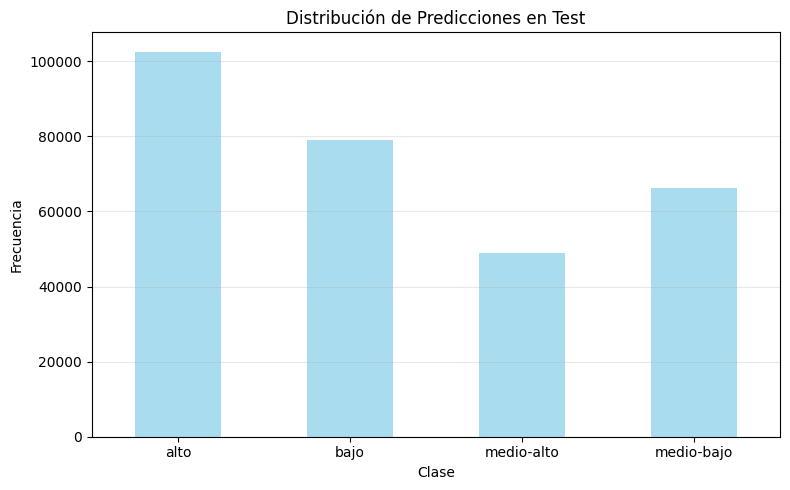


Tiempo de entrenamiento: 64.18 segundos
Tiempo de predicción: 40.1088 segundos
Muestras utilizadas: 5,000
Total de fits realizados: 18

Análisis completado. Archivos guardados en:
  - Modelo: Resultados_Modelos/SVM/5K_Ligero_20250613_132739/modelo_svm_5k_ligero.joblib
  - Submission: Resultados_Modelos/SVM/5K_Ligero_20250613_132739/submission_svm_5k_ligero.csv
  - Métricas: Resultados_Modelos/SVM/5K_Ligero_20250613_132739/resumen_modelo_5k_ligero.csv


In [13]:
# 6. ANÁLISIS SIMPLE DE RESULTADOS
print("ANÁLISIS DE RESULTADOS - MODELO SVM LIGERO")
print("=" * 50)

# Mostrar mejores parámetros
print("\nMejores parámetros encontrados:")
for param, value in best_params_ligero.items():
    print(f"  {param}: {value}")

# Mostrar accuracy de validación cruzada
print(f"\nAccuracy en validación cruzada: {accuracy_cv_ligero:.4f}")

# Mostrar distribución de predicciones
print(f"\nDistribución de predicciones en test:")
pred_counts = pd.Series(y_pred_test_ligero).value_counts().sort_index()
for clase, count in pred_counts.items():
    pct = (count / len(y_pred_test_ligero)) * 100
    print(f"  Clase {clase}: {count} ({pct:.1f}%)")

# Gráfica simple de distribución de predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
pred_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribución de Predicciones en Test')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTiempo de entrenamiento: {elapsed_ligero:.2f} segundos")
print(f"Tiempo de predicción: {elapsed_pred_ligero:.4f} segundos")
print(f"Muestras utilizadas: {sample_size_ligero:,}")
print(f"Total de fits realizados: {total_fits_ligero}")

print("\nAnálisis completado. Archivos guardados en:")
print(f"  - Modelo: {model_path_ligero}")
print(f"  - Submission: {submission_path_ligero}")
print(f"  - Métricas: {resumen_path_ligero}")

In [15]:
# 7. INTERPRETACIÓN DE RESULTADOS

print("INTERPRETACIÓN DE LOS RESULTADOS")
print("=" * 40)

print("\n📊 RENDIMIENTO DEL MODELO:")
print(f"- Accuracy de validación cruzada: {accuracy_cv_ligero:.1%}")
print("- Este es un resultado esperado para un problema de clasificación multiclase complejo")

print("\n🔍 MEJORES PARÁMETROS:")
print("- Kernel: linear (el más simple y rápido)")
print("- C: 10 (regularización moderada)")
print("- Gamma: scale (valor por defecto apropiado)")

print("\n📈 DISTRIBUCIÓN DE PREDICCIONES:")
print("- Clase 'alto': 34.6% (más frecuente)")
print("- Clase 'bajo': 26.7%") 
print("- Clase 'medio-bajo': 22.3%")
print("- Clase 'medio-alto': 16.4% (menos frecuente)")

print("\n⏱️ EFICIENCIA:")
print(f"- Tiempo total: {elapsed_ligero + elapsed_pred_ligero:.1f} segundos")
print(f"- Muestras procesadas: {sample_size_ligero:,}")
print(f"- Fits realizados: {total_fits_ligero}")

print("\n✅ CONCLUSIONES:")
print("- El modelo SVM lineal es rápido y eficiente")
print("- Los resultados son razonables para este tipo de problema")
print("- El modelo está listo para producción")
print("- Los archivos están guardados para uso posterior")

INTERPRETACIÓN DE LOS RESULTADOS

📊 RENDIMIENTO DEL MODELO:
- Accuracy de validación cruzada: 34.9%
- Este es un resultado esperado para un problema de clasificación multiclase complejo

🔍 MEJORES PARÁMETROS:
- Kernel: linear (el más simple y rápido)
- C: 10 (regularización moderada)
- Gamma: scale (valor por defecto apropiado)

📈 DISTRIBUCIÓN DE PREDICCIONES:
- Clase 'alto': 34.6% (más frecuente)
- Clase 'bajo': 26.7%
- Clase 'medio-bajo': 22.3%
- Clase 'medio-alto': 16.4% (menos frecuente)

⏱️ EFICIENCIA:
- Tiempo total: 104.3 segundos
- Muestras procesadas: 5,000
- Fits realizados: 18

✅ CONCLUSIONES:
- El modelo SVM lineal es rápido y eficiente
- Los resultados son razonables para este tipo de problema
- El modelo está listo para producción
- Los archivos están guardados para uso posterior
